In [1]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
import random
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from nltk.translate.bleu_score import sentence_bleu
import torchvision.transforms.functional as F
import torch.nn.functional as nF

In [3]:
# Ignore all warnings
warnings.filterwarnings("ignore")

In [4]:
import zipfile

# Unzipping Flickr8k_Dataset.zip
with zipfile.ZipFile('/content/drive/MyDrive/Flickr8k_Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Flickr8k_Dataset')

# Unzipping Flickr8k_text.zip
with zipfile.ZipFile('/content/drive/MyDrive/Flickr8k_text.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Flickr8k_text')


In [5]:
# Paths
image_dir = '/content/Flickr8k_Dataset/Flicker8k_Dataset'
annotations_file = '/content/Flickr8k_text/Flickr8k.token.txt'
train_file = '/content/Flickr8k_text/Flickr_8k.trainImages.txt'
val_file = '/content/Flickr8k_text/Flickr_8k.devImages.txt'
test_file = '/content/Flickr8k_text/Flickr_8k.testImages.txt'

# Read annotations
with open(annotations_file, 'r') as f:
    annotations = f.readlines()

# Create a dictionary for image captions
captions_dict = {}
for line in annotations:
    img_name, caption = line.strip().split('\t')
    img_name = img_name.split('#')[0]
    if img_name not in captions_dict:
        captions_dict[img_name] = []
    captions_dict[img_name].append(caption)

# Load train, val, and test image names
def load_image_names(file_path):
    with open(file_path, 'r') as f:
        return f.read().strip().split('\n')

train_img_names = load_image_names(train_file)
val_img_names = load_image_names(val_file)
test_img_names = load_image_names(test_file)


In [6]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        return self.word2idx.get(word, self.word2idx['<unk>'])

    def __len__(self):
        return len(self.word2idx)

In [7]:
# Initialize vocabulary
vocab = Vocabulary()

# Add special tokens
special_tokens = ['<pad>', '<start>', '<end>', '<unk>']
for token in special_tokens:
    vocab.add_word(token)

# Tokenize and add words to the vocabulary
for img_name, captions in captions_dict.items():
    for caption in captions:
        tokens = caption.split()  # Simple whitespace tokenizer
        for token in tokens:
            vocab.add_word(token)

print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 9634


In [8]:
# Sample a percentage of the training and validation data
def sample_data(img_names, percentage):
    sample_size = int(len(img_names) * percentage)
    return random.sample(img_names, sample_size)

train_img_names_sampled = sample_data(train_img_names, 0.8)  # Sample 80% of images for training
val_img_names_sampled = sample_data(val_img_names, 0.8)  # Sample 80% of images for validation

# Use the full dataset
#train_img_names_sampled = train_img_names  # Use all images for training
#val_img_names_sampled = val_img_names  # Use all images for validation

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Define collate_fn function
def collate_fn(data):
    images, captions = zip(*data)
    images = torch.stack(images, 0)

    # Tokenize captions and convert to indices
    tokenizer = lambda x: x.split()  # Simple whitespace tokenizer
    captions = [[vocab(token) for token in tokenizer(caption)] for caption in captions]

    # Find the length of the longest caption
    max_len = max(len(caption) for caption in captions)

    # Pad all captions to the same length
    padded_captions = []
    for caption in captions:
        padded_caption = caption + [vocab('<pad>')] * (max_len - len(caption))
        padded_captions.append(padded_caption)

    # Convert to tensor
    captions = torch.tensor(padded_captions)

    return images, captions

class Flickr8kDataset(Dataset):
    def __init__(self, img_names, captions_dict, img_dir, transform=None):
        self.img_names = img_names
        self.captions_dict = captions_dict
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        caption = random.choice(self.captions_dict[img_name])  # Choose a random caption for the image
        return image, caption

# Create dataset objects
train_dataset = Flickr8kDataset(train_img_names_sampled, captions_dict, image_dir, transform)
val_dataset = Flickr8kDataset(val_img_names_sampled, captions_dict, image_dir, transform)
test_dataset = Flickr8kDataset(test_img_names, captions_dict, image_dir, transform)

# Create data loaders with collate_fn
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [9]:
# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        googlenet = models.googlenet(pretrained=True)

        # Unfreeze the last few layers
        for param in list(googlenet.parameters())[-10:]:
            param.requires_grad = True

        self.googlenet = nn.Sequential(*list(googlenet.children())[:-2])
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(googlenet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        # Additional layers
        self.fc1 = nn.Linear(embed_size, embed_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.googlenet(images)
        features = self.adaptive_pool(features).reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        features = self.dropout(nF.relu(self.fc1(features)))  # Corrected this line
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

    def sample(self, features, states=None, max_len=20):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        batch_size = features.size(0)
        for i in range(max_len):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
            if (predicted == vocab('<end>')).all():
                break
        sampled_ids = torch.stack(sampled_ids, 1)
        return sampled_ids

# Instantiate encoder and decoder
embed_size = 256
hidden_size = 512
vocab_size = len(vocab)  # Update based on your vocabulary size

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size).to(device)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 147MB/s]


In [11]:
def generate_captions(encoder, decoder, data_loader, vocab, max_length=20):
    encoder.eval()
    decoder.eval()
    all_images = []
    all_captions = []

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            features = encoder(images)
            sampled_ids = decoder.sample(features, max_len=max_length)
            sampled_ids = sampled_ids.cpu().numpy()

            for i, image in enumerate(images):
                all_images.append(image.cpu())
                caption = []
                for word_id in sampled_ids[i]:
                    word = vocab.idx2word[word_id]
                    if word == '<end>':
                        break
                    if word != '<pad>':
                        caption.append(word)
                caption = ' '.join(caption)
                all_captions.append(caption)

    return all_images, all_captions

def visualize_captions(images, captions, num_samples=5):
    num_samples = min(num_samples, len(images))  # Ensure num_samples does not exceed available images
    plt.figure(figsize=(15, 15))

    for i in range(num_samples):
        plt.subplot((num_samples + 1) // 2, 2, i + 1)
        image = images[i]
        if isinstance(image, torch.Tensor):
            print(f"Original image shape: {image.shape}")
            image = image.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
            print(f"Permuted image shape: {image.shape}")
            image = image.numpy()
            print(f"Numpy image shape: {image.shape}")
            image = transforms.ToPILImage()(image)
            print(f"Converted image type: {type(image)}")
        plt.imshow(image)
        plt.title(captions[i])
        plt.axis('off')
    plt.show()

In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = optim.Adam(params, lr=0.001)

In [13]:
# Training loop
num_epochs = 20
log_step = 5

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    for i, (images, captions) in enumerate(train_loader):
        images = images.to(device)
        captions = captions.to(device)

        # Debugging: Print shapes of inputs
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}]")
        print(f"Images shape: {images.shape}")
        print(f"Captions shape: {captions.shape}")

        features = encoder(images)
        outputs = decoder(features, captions)

        # Debugging: Print shapes of model outputs
        print(f"Features shape: {features.shape}")
        print(f"Outputs shape: {outputs.shape}")

        batch_size, sequence_length, _ = outputs.shape
        targets = captions[:, 1:]

        if targets.shape[1] < sequence_length:
            padding = torch.full((batch_size, sequence_length - targets.shape[1]), vocab('<pad>')).to(device)
            targets = torch.cat((targets, padding), dim=1)
        elif targets.shape[1] > sequence_length:
            targets = targets[:, :sequence_length]

        # Debugging: Print shapes of targets after padding
        print(f"Targets shape: {targets.shape}")

        loss = criterion(outputs.view(batch_size * sequence_length, -1), targets.reshape(-1))

        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        if i % log_step == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}')


Streaming output truncated to the last 5000 lines.
Features shape: torch.Size([32, 256])
Outputs shape: torch.Size([32, 20, 9634])
Targets shape: torch.Size([32, 20])
Epoch [15/20], Step [94/150]
Images shape: torch.Size([32, 3, 224, 224])
Captions shape: torch.Size([32, 26])
Features shape: torch.Size([32, 256])
Outputs shape: torch.Size([32, 27, 9634])
Targets shape: torch.Size([32, 27])
Epoch [15/20], Step [95/150]
Images shape: torch.Size([32, 3, 224, 224])
Captions shape: torch.Size([32, 23])
Features shape: torch.Size([32, 256])
Outputs shape: torch.Size([32, 24, 9634])
Targets shape: torch.Size([32, 24])
Epoch [15/20], Step [95/150], Loss: 1.6912
Epoch [15/20], Step [96/150]
Images shape: torch.Size([32, 3, 224, 224])
Captions shape: torch.Size([32, 18])
Features shape: torch.Size([32, 256])
Outputs shape: torch.Size([32, 19, 9634])
Targets shape: torch.Size([32, 19])
Epoch [15/20], Step [97/150]
Images shape: torch.Size([32, 3, 224, 224])
Captions shape: torch.Size([32, 19])
Fe

In [14]:
def tensor_to_word_fn(tensor, vocab):
    try:
        return [vocab.idx2word[idx.item()] for idx in tensor if idx.item() not in [vocab('<pad>'), vocab('<start>'), vocab('<end>'), vocab('<unk>')]]
    except KeyError as e:
        print(f"KeyError: {e}")
        return ["<unk>"]

In [15]:
def corpus_bleu_score_fn(references, candidates):
    smooth = SmoothingFunction().method1
    bleu_scores = [sentence_bleu([ref], cand, smoothing_function=smooth) for ref, cand in zip(references, candidates)]
    return sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0

In [16]:
# Define evaluate_model for encoder-decoder structure
def evaluate_model(desc, encoder, decoder, data_loader, vocab, bleu_score_fn, tensor_to_word_fn, loss_fn=None):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    references, candidates = [], []

    with torch.no_grad():
        for images, captions in tqdm(data_loader, desc=desc, leave=False):
            images = images.to(device)
            captions = captions.to(device)
            features = encoder(images)
            outputs = decoder.sample(features)

            if loss_fn:
                outputs = decoder(features, captions)
                loss = loss_fn(outputs.view(-1, outputs.size(2)), captions.view(-1))
                total_loss += loss.item()

            for i in range(len(captions)):
                ref = tensor_to_word_fn(captions[i], vocab)
                cand = tensor_to_word_fn(outputs[i], vocab)
                references.append(ref)
                candidates.append(cand)

    avg_loss = total_loss / len(data_loader) if loss_fn else 0
    bleu_score = bleu_score_fn(references, candidates)

    print(f'{desc} Avg Loss: {avg_loss:.4f} BLEU: {bleu_score:.4f}')

    return bleu_score

In [17]:
# Define evaluate
def evaluate(encoder, decoder, loader):
    encoder.eval()
    decoder.eval()
    smooth = SmoothingFunction().method1
    total_bleu1, total_bleu2, total_bleu3, total_bleu4 = 0, 0, 0, 0
    count = 0
    with torch.no_grad():
        for images, captions in tqdm(loader, desc='Evaluation', leave=False):
            images = images.to(device)
            captions = captions.to(device)
            features = encoder(images)
            outputs = decoder.sample(features)

            for i, output in enumerate(outputs):
                reference = [vocab.idx2word[idx] for idx in captions[i].tolist() if idx not in [vocab('<pad>'), vocab('<start>'), vocab('<end>'), vocab('<unk>')]]
                candidate = [vocab.idx2word[idx.item()] for idx in output if idx.item() not in [vocab('<pad>'), vocab('<start>'), vocab('<end>'), vocab('<unk>')]]
                reference = [reference]  # BLEU expects a list of reference lists
                total_bleu1 += sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=smooth)
                total_bleu2 += sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
                total_bleu3 += sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth)
                total_bleu4 += sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)
                count += 1

    return total_bleu1/count, total_bleu2/count, total_bleu3/count, total_bleu4/count

In [18]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm

In [19]:
# Main evaluation logic
with torch.no_grad():
    encoder.eval()
    decoder.eval()

    # Train BLEU
    train_bleu = evaluate_model(
        desc='Train: ',
        encoder=encoder,
        decoder=decoder,
        data_loader=train_loader,
        vocab=vocab,
        bleu_score_fn=corpus_bleu_score_fn,
        tensor_to_word_fn=tensor_to_word_fn,
        loss_fn=None  # Replace with actual loss function if needed
    )

    # Validation BLEU
    val_bleu = evaluate_model(
        desc='Val: ',
        encoder=encoder,
        decoder=decoder,
        data_loader=val_loader,
        vocab=vocab,
        bleu_score_fn=corpus_bleu_score_fn,
        tensor_to_word_fn=tensor_to_word_fn,
        loss_fn=None  # Replace with actual loss function if needed
    )

    # Test BLEU
    test_bleu = evaluate_model(
        desc='Test: ',
        encoder=encoder,
        decoder=decoder,
        data_loader=test_loader,
        vocab=vocab,
        bleu_score_fn=corpus_bleu_score_fn,
        tensor_to_word_fn=tensor_to_word_fn,
        loss_fn=None  # Replace with actual loss function if needed
    )

    for setname, result in zip(('train', 'val', 'test'), (train_bleu, val_bleu, test_bleu)):
        print(f"{setname} Bleu-1: {result:.4f} Bleu-2: {result:.4f} Bleu-3: {result:.4f} Bleu-4: {result:.4f}")

Train:  Avg Loss: 0.0000 BLEU: 0.0182


Val:  Avg Loss: 0.0000 BLEU: 0.0174


Test:  Avg Loss: 0.0000 BLEU: 0.0172
train Bleu-1: 0.0182 Bleu-2: 0.0182 Bleu-3: 0.0182 Bleu-4: 0.0182
val Bleu-1: 0.0174 Bleu-2: 0.0174 Bleu-3: 0.0174 Bleu-4: 0.0174
test Bleu-1: 0.0172 Bleu-2: 0.0172 Bleu-3: 0.0172 Bleu-4: 0.0172


Original image shape: torch.Size([3, 224, 224])
Permuted image shape: torch.Size([224, 224, 3])
Numpy image shape: (224, 224, 3)
Converted image type: <class 'PIL.Image.Image'>
Original image shape: torch.Size([3, 224, 224])
Permuted image shape: torch.Size([224, 224, 3])
Numpy image shape: (224, 224, 3)
Converted image type: <class 'PIL.Image.Image'>
Original image shape: torch.Size([3, 224, 224])
Permuted image shape: torch.Size([224, 224, 3])
Numpy image shape: (224, 224, 3)
Converted image type: <class 'PIL.Image.Image'>
Original image shape: torch.Size([3, 224, 224])
Permuted image shape: torch.Size([224, 224, 3])
Numpy image shape: (224, 224, 3)
Converted image type: <class 'PIL.Image.Image'>
Original image shape: torch.Size([3, 224, 224])
Permuted image shape: torch.Size([224, 224, 3])
Numpy image shape: (224, 224, 3)
Converted image type: <class 'PIL.Image.Image'>


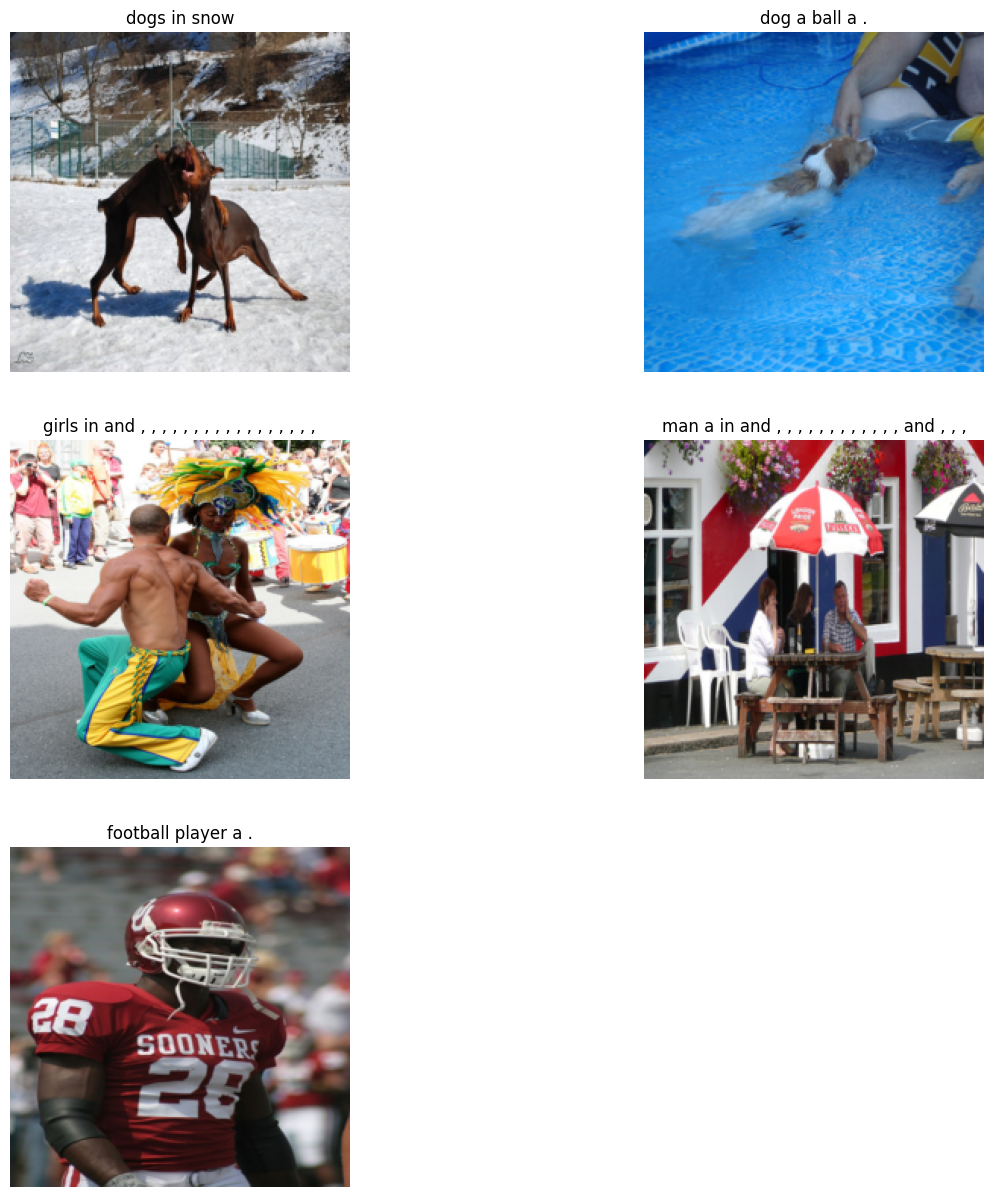

In [20]:
all_images, all_captions = generate_captions(encoder, decoder, test_loader, vocab)

# Visualize the captions
visualize_captions(all_images, all_captions, num_samples=5)